In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Veriyi yükleyelim
df = pd.read_csv('data/year_2009_2010.csv',encoding='latin1')

In [11]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,12/1/2009 7:45,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,12/1/2009 7:45,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,12/1/2009 7:45,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,12/1/2009 7:46,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,12/1/2009 7:46,3.75,13085.0,United Kingdom


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [14]:
# Veri ön işleme
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df = df.dropna(subset=['Customer ID'])
df['Customer ID'] = df['Customer ID'].astype('str')
# NaN değerlerin silindiğini kontrol edin
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 417534 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  object        
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 28.7+ MB
None


In [31]:
df.describe()

,Quantity,InvoiceDate,Price
count,417534.000000,417534,417534.000000
mean,12.758815,2010-07-01 01:12:19.787609856,3.887547
min,-9360.000000,2009-12-01 07:45:00,0.000000
25%,2.000000,2010-03-26 11:26:00,1.250000
50%,4.000000,2010-07-08 19:12:00,1.950000
75%,12.000000,2010-10-14 14:08:00,3.750000
max,19152.000000,2010-12-09 20:01:00,25111.090000
std,101.220424,NaN,71.131797


In [15]:
# RFM metriklerini hesaplamak için bugünkü tarihi belirleyelim
today_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

print(today_date)

2010-12-10 20:01:00


In [16]:
# RFM metriklerini hesaplayalım
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (today_date - date.max()).days,
    'Invoice': 'nunique',
    'Price': 'sum'
})

In [17]:

# Kolon isimlerini değiştirelim
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [18]:
# RFM puanlarını hesaplayalım
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])


In [19]:
# RFM skoru hesaplayalım
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


In [20]:
# Segmentlere ayıralım
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[3-4][1-2]': 'At Risk',
    r'[4-5][4-5]': 'Champions',
    r'[3-4][3-4]': 'Loyal Customers',
    r'[1-2][4-5]': 'New Customers'
}

In [21]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)


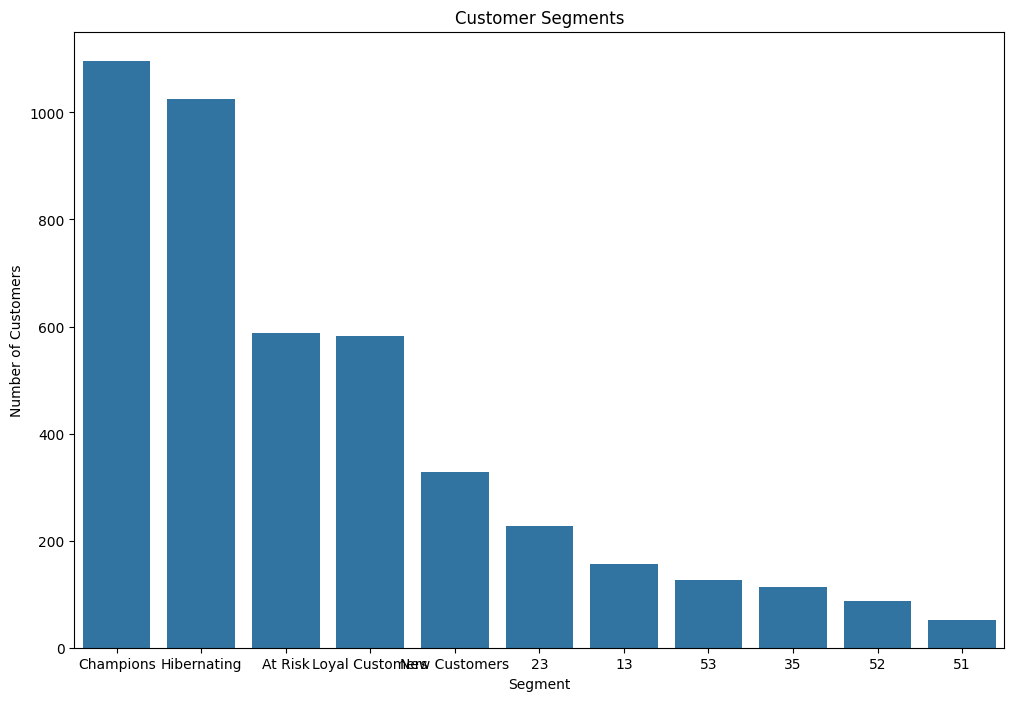

In [22]:
# Segment dağılımını görselleştirelim
plt.figure(figsize=(12,8))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

In [23]:
# Segment bazında ortalama RFM metriklerini hesaplayalım
segment_metrics = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)


In [24]:
segment_metrics.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
print(segment_metrics)


                 RecencyMean  FrequencyMean  MonetaryMean  Count
Segment                                                         
13                     247.0            2.6         379.0    157
23                     111.9            2.8         156.8    227
35                      51.8           11.8        1071.6    113
51                       8.4            1.0          77.6     52
52                       9.3            1.7         124.9     88
53                       7.1            2.8         191.8    126
At Risk                 41.1            1.4          98.4    588
Champions               13.2           13.0         789.0   1096
Hibernating            215.8            1.2         126.1   1025
Loyal Customers         44.0            3.7         257.5    582
New Customers          130.8            6.7         505.0    329


In [25]:
rfm.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4383 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4383 non-null   int64   
 1   Frequency  4383 non-null   int64   
 2   Monetary   4383 non-null   float64 
 3   R          4383 non-null   category
 4   F          4383 non-null   category
 5   M          4383 non-null   category
 6   RFM_Score  4383 non-null   object  
 7   Segment    4383 non-null   object  
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 348.0+ KB


In [29]:
from sklearn.model_selection import train_test_split

# Özellik mühendisliği yapın
data = df.copy()

data['TotalPrice'] = data['Quantity'] * data['Price']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Recency'] = (data['InvoiceDate'].max() - data['InvoiceDate']).dt.days



In [30]:
# İlgili sütunları seçin
features = data[['Recency', 'Quantity', 'TotalPrice']]
target = (data['Recency'] < 100).astype(int)  # Son 30 gün içinde alışveriş yapıp yapmadığını hedef olarak kullanın

# Eğitim ve test setlerini oluşturun
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)